<a href="https://colab.research.google.com/github/Gilangp/Machine-learning/blob/main/week%207/TG2_JS07_2341720042_Gilang_Purnomo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tugas Praktikum 2**

Lakukan percobaan penggunaan ANNOY, FAISS, dan HNSWLIB pada dataset sekunder berukuran besar (Micro Spotify) pada link berikut: https://www.kaggle.com/datasets/bwandowando/spotify-songs-with-attributes-and-lyrics/data .

* Download data dan load CSV filenya (pilih dataset yg pertama dari dua dataset).

In [ ]:
!pip install annoy
!pip install faiss-cpu
!pip install faiss-gpu
!pip install hnswlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551811 sha256=8cb3e171df0bb7144766f851d0a3395a7a20b4427a677a83c902fea1dfb73f67
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 56.1 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hnswlib: filename=hnswlib-0.8.0-cp312-cp312-linux_x86_64.whl size=2528143 sha256=d92a28b759077694269c6e8ab0717cc45a853f26b7cd5011d29a34c2537f3320
  Stored in directory: /root/.cache/pip/wheels/ac/39/b3/c

In [ ]:
import pandas as pd
import numpy as np
import time
import faiss
from annoy import AnnoyIndex
import hnswlib
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

df = pd.read_csv("songs_with_attributes_and_lyrics.csv",
                 delimiter=",",
                 quotechar='"',
                 on_bad_lines='skip',
                 engine='python')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                3858 non-null   object 
 1   name              3858 non-null   object 
 2   album_name        1648 non-null   object 
 3   artists           3858 non-null   object 
 4   danceability      3858 non-null   float64
 5   energy            3858 non-null   float64
 6   key               3858 non-null   object 
 7   loudness          3858 non-null   float64
 8   mode              3858 non-null   object 
 9   speechiness       3858 non-null   float64
 10  acousticness      3858 non-null   float64
 11  instrumentalness  3858 non-null   float64
 12  liveness          3858 non-null   float64
 13  valence           3858 non-null   float64
 14  tempo             3858 non-null   float64
 15  duration_ms       3858 non-null   float64
 16  lyrics            3858 non-null   object 


* Pilih hanya fitur numerik saja, dan lakukan normalisasi menggunakan **StandardScaler**.

In [ ]:
features = [
    'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]

X = df[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

np.random.seed(42)
query_index = np.random.randint(0, len(X_scaled))
query = X_scaled[query_index].reshape(1, -1)

k = 10

* Lakukan pencarian track terdekat dan bandingkan hasilnya.

In [ ]:
# ---------- Exact Nearest Neighbors ----------
print("=== Exact Nearest Neighbors (Sklearn) ===")
nbrs = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
start_time = time.time()
nbrs.fit(X_scaled)
distances_exact, indices_exact = nbrs.kneighbors(query)
time_exact = time.time() - start_time
print(f"Waktu pencarian: {time_exact:.4f} detik")

# ---------- ANNOY ----------
print("\n=== ANNOY ===")
dim = X_scaled.shape[1]
annoy_index = AnnoyIndex(dim, 'euclidean')
start_time = time.time()
for i, vec in enumerate(X_scaled):
    annoy_index.add_item(i, vec)
annoy_index.build(10)  # jumlah trees
indices_annoy = annoy_index.get_nns_by_vector(query.flatten(), k, include_distances=False)
time_annoy = time.time() - start_time
print(f"Waktu pencarian (termasuk build): {time_annoy:.4f} detik")

# ---------- FAISS ----------
print("\n=== FAISS ===")
d = X_scaled.shape[1]
index_faiss = faiss.IndexFlatL2(d)
start_time = time.time()
index_faiss.add(X_scaled.astype('float32'))
distances_faiss, indices_faiss = index_faiss.search(query.astype('float32'), k)
time_faiss = time.time() - start_time
print(f"Waktu pencarian (termasuk build): {time_faiss:.4f} detik")

# ---------- HNSWLIB ----------
print("\n=== HNSWLIB ===")
dim = X_scaled.shape[1]
num_elements = X_scaled.shape[0]
p = hnswlib.Index(space='l2', dim=dim)
start_time = time.time()
p.init_index(max_elements=num_elements, ef_construction=200, M=16)
p.add_items(X_scaled)
p.set_ef(50)
labels, distances = p.knn_query(query, k=k)
time_hnsw = time.time() - start_time
print(f"Waktu pencarian (termasuk build): {time_hnsw:.4f} detik")

=== Exact Nearest Neighbors (Sklearn) ===
Waktu pencarian: 0.0576 detik

=== ANNOY ===
Waktu pencarian (termasuk build): 0.0903 detik

=== FAISS ===
Waktu pencarian (termasuk build): 0.0009 detik

=== HNSWLIB ===
Waktu pencarian (termasuk build): 0.3297 detik


* Lakkan perbandingan pada exact NN, ANNOY, FAISS, dan HNSW


=== PERBANDINGAN HASIL DAN WAKTU ===
Exact NN waktu     : 0.0576 detik
ANNOY waktu        : 0.0903 detik
FAISS waktu        : 0.0009 detik
HNSWLIB waktu      : 0.3297 detik

Indeks hasil pencarian:
Exact NN : [3174 3175 3214 3261  382 2950  604 1732   77 3771]
ANNOY    : [3174, 3175, 3214, 3261, 382, 2950, 604, 1732, 77, 3771]
FAISS    : [3174 3175 3214 3261  382 2950  604 1732   77 3771]
HNSWLIB  : [3174 3175 3214 3261  382 2950  604 1732   77 3771]


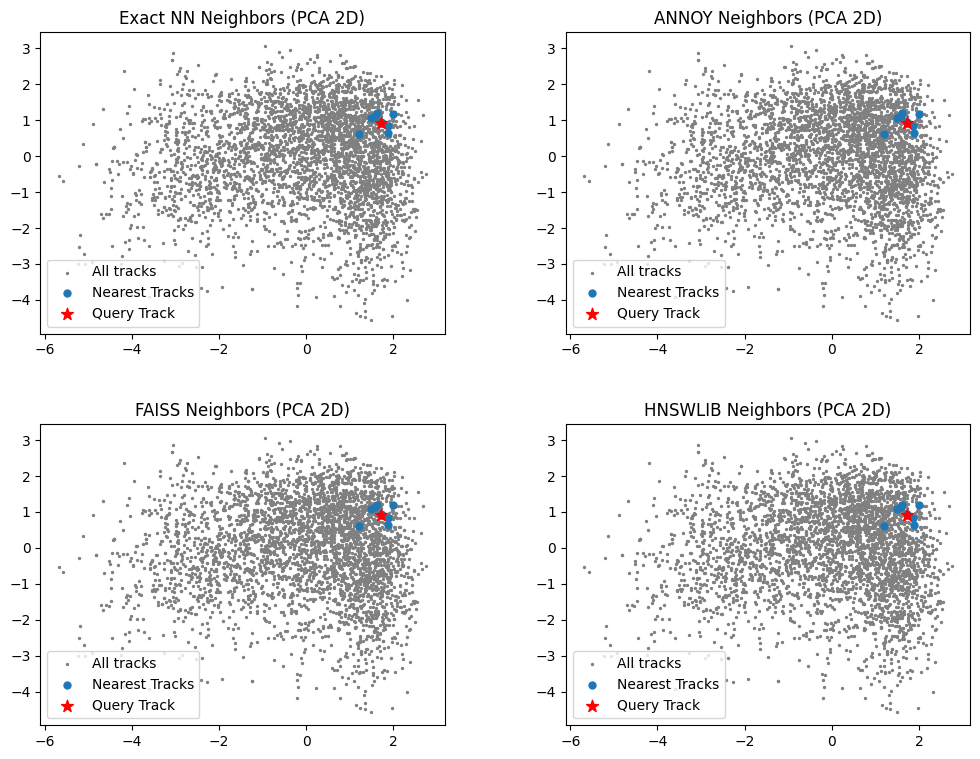

In [ ]:
print("\n=== PERBANDINGAN HASIL DAN WAKTU ===")
print(f"Exact NN waktu     : {time_exact:.4f} detik")
print(f"ANNOY waktu        : {time_annoy:.4f} detik")
print(f"FAISS waktu        : {time_faiss:.4f} detik")
print(f"HNSWLIB waktu      : {time_hnsw:.4f} detik")

print("\nIndeks hasil pencarian:")
print("Exact NN :", indices_exact.flatten())
print("ANNOY    :", indices_annoy)
print("FAISS    :", indices_faiss.flatten())
print("HNSWLIB  :", labels.flatten())

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
query_pca = X_pca[query_index]

fig, axes = plt.subplots(2, 2, figsize=(12, 9))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

titles = ["Exact NN", "ANNOY", "FAISS", "HNSWLIB"]
neighbors_list = [
    indices_exact.flatten(),
    indices_annoy,
    indices_faiss.flatten(),
    labels.flatten()
]

for ax, title, neighbors in zip(axes.ravel(), titles, neighbors_list):
    ax.scatter(X_pca[:, 0], X_pca[:, 1], s=2, color='gray', label='All tracks')
    ax.scatter(X_pca[neighbors, 0], X_pca[neighbors, 1], s=25, label='Nearest Tracks')
    ax.scatter(query_pca[0], query_pca[1], s=80, color='red', marker='*', label='Query Track')
    ax.set_title(f"{title} Neighbors (PCA 2D)")
    ax.legend()

plt.show()